# Setup

In [1]:
# Used to read .env files, for access tokens and other secrets or configurations
%load_ext dotenv
%dotenv
import os

In [2]:
import math

In [3]:
from github import Github
import pandas
from matplotlib import pyplot
import numpy
import seaborn

from datetime import datetime, timedelta

In [4]:
from IPython.core.pylabtools import figsize
figsize(10, 5)

In [5]:
# The github token is stored in a .env file next to this notebook in the form "GITHUB_TOKEN = <your token here>"
github = Github(os.getenv("GITHUB_TOKEN"))

# Team Constants

These are things that describe how the team work and are static

## Sprint Management

In [6]:
# In the following, we will assume that sprints are totally regular, starting with a fixed date.
# The helper functions can of course be adapted to represent, e.g., changes in sprint duration or holiday breaks

start_date_first_sprint = datetime(2020, 4, 27) # It's a monday, development actually started 02.05.2020
sprint_length = timedelta(weeks=2)

def date_to_sprint(date_to_convert):
    return max(0, (date_to_convert - start_date_first_sprint) // sprint_length + 1) # Sprint "0" is everything before the first

def sprint_to_start_date(sprint_to_convert):
    return (start_date_first_sprint + (sprint_to_convert - 1) * sprint_length)

def date_to_sprint_start(date_to_convert):
    return sprint_to_start_date(date_to_sprint(date_to_convert))

## Repos

In [7]:
app_repo = github.get_repo('corona-warn-app/cwa-app-android')

## Team Members

In [8]:
# Let's assume that all developers with less than 5 commits were not active developers
app_team = list(map(lambda stats: stats.author, filter(lambda stats: stats.total >= 15, app_repo.get_stats_contributors())))
app_team

[NamedUser(login="mlenkeit"),
 NamedUser(login="MikeMcC399"),
 NamedUser(login="ksergeevit"),
 NamedUser(login="tklingbeil"),
 NamedUser(login="tkowark"),
 NamedUser(login="CV113"),
 NamedUser(login="fynngodau"),
 NamedUser(login="oemerb"),
 NamedUser(login="kaddaSz"),
 NamedUser(login="AndroidMedaGalaxy"),
 NamedUser(login="Fabian-K"),
 NamedUser(login="HeeTattSap"),
 NamedUser(login="marcmuschko"),
 NamedUser(login="NataliaLemmerth"),
 NamedUser(login="KathrinLuecke"),
 NamedUser(login="Oliver-Zimmerman"),
 NamedUser(login="chris-cwa"),
 NamedUser(login="pwoessner"),
 NamedUser(login="janetback"),
 NamedUser(login="schauersbergern"),
 NamedUser(login="LukasLechnerDev"),
 NamedUser(login="kolyaopahle"),
 NamedUser(login="axelherbstreith"),
 NamedUser(login="service-tip-git"),
 NamedUser(login="AlexanderAlferov"),
 NamedUser(login="jakobmoellersap"),
 NamedUser(login="marcauberer"),
 NamedUser(login="Corona-Warn-App-Technical-User"),
 NamedUser(login="chiljamgossow"),
 NamedUser(login=

# Retrospective

In [9]:
today = date_to_sprint_start(datetime(day=1, month=8, year=2022)) # Normally this would of course be the real today
time_of_interest = date_to_sprint_start(today - timedelta(days=365))
(today, time_of_interest)

(datetime.datetime(2022, 8, 1, 0, 0), datetime.datetime(2021, 7, 19, 0, 0))

## Data Collection and Preprocessing

In [10]:
repo = app_repo

In [11]:
%%time
issues_raw = repo.get_issues(state='all', since=time_of_interest)
issues_dataframe = pandas.DataFrame(issues_raw, columns=['issue'])

CPU times: user 2.19 s, sys: 0 ns, total: 2.19 s
Wall time: 41 s


In [12]:
issues_dataframe['issue_number'] = issues_dataframe.issue.apply(lambda issue: issue.number)
issues_dataframe['created_at'] = issues_dataframe.issue.apply(lambda issue: issue.created_at)
issues_dataframe['created_sprint'] = issues_dataframe.created_at.apply(lambda date: date_to_sprint_start(date).date())
issues_dataframe = issues_dataframe[(issues_dataframe.created_at >= time_of_interest) & (issues_dataframe.created_at < today)]
issues_dataframe

,issue,issue_number,created_at,created_sprint
299,"Issue(title=""Hinweis zur Auffrischimpfung Bena...",5400,2022-07-31 18:29:36,2022-07-18
300,"Issue(title=""Fix back navigation for UQS when ...",5399,2022-07-29 11:34:16,2022-07-18
301,"Issue(title=""https link to RKI STIKO (EXPOSURE...",5398,2022-07-29 06:50:46,2022-07-18
302,"Issue(title=""Status update is not working on a...",5397,2022-07-28 23:57:50,2022-07-18
303,"Issue(title=""Support Material You themed icons...",5396,2022-07-28 20:43:32,2022-07-18
...,...,...,...,...
1910,"Issue(title=""Pass rawCOSEObject (EXPOSUREAPP-8...",3747,2021-07-19 13:58:17,2021-07-19
1911,"Issue(title=""Title Change(EXPOSUREAPP-8422)"", ...",3746,2021-07-19 12:36:48,2021-07-19
1912,"Issue(title=""Fix :Rule counter on success scre...",3745,2021-07-19 11:02:55,2021-07-19
1913,"Issue(title=""UA Bug fix (DEV)"", number=3744)",3744,2021-07-19 08:45:03,2021-07-19


In [13]:
%%time
def is_issue(issue): # "Issues" returned by GitHub API can also be Pull Requests which we want to ignore
    return 'issues' in issue.html_url

def is_customer_issue(issue): # Issues created by the development team do not represent customer interaction
    return is_issue(issue) and not issue.user in app_team

customer_issues = issues_dataframe[issues_dataframe.issue.apply(is_customer_issue)]
customer_issues

CPU times: user 23.7 ms, sys: 0 ns, total: 23.7 ms
Wall time: 21.7 ms


,issue,issue_number,created_at,created_sprint
299,"Issue(title=""Hinweis zur Auffrischimpfung Bena...",5400,2022-07-31 18:29:36,2022-07-18
302,"Issue(title=""Status update is not working on a...",5397,2022-07-28 23:57:50,2022-07-18
303,"Issue(title=""Support Material You themed icons...",5396,2022-07-28 20:43:32,2022-07-18
330,"Issue(title=""v2.25.0-RC2 is tagged as ""Lates"" ...",5368,2022-07-20 12:15:11,2022-07-18
343,"Issue(title=""Contact Journal: Duration of plac...",5354,2022-07-16 09:20:08,2022-07-04
...,...,...,...,...
1810,"Issue(title=""[Solved]: Uniform / identical num...",3849,2021-07-30 17:53:30,2021-07-19
1812,"Issue(title=""Validity check for Netherlands do...",3847,2021-07-30 14:27:36,2021-07-19
1821,"Issue(title=""Latest issued Vaccination DCC 2/2...",3838,2021-07-29 13:07:35,2021-07-19
1856,"Issue(title=""[INFO / Bug]: Update problem afte...",3802,2021-07-26 09:13:23,2021-07-19


## Finding Problems: Long Reaction Times

In [14]:
def first_reaction(issue):
    return next((comment for comment in issue.get_comments() if comment.user != issue.user), None)

In [15]:
%%time
customer_issues['first_reaction'] = customer_issues.issue.apply(first_reaction)
customer_issues['time_to_react'] = customer_issues.first_reaction.apply(lambda comment: comment and comment.created_at) - customer_issues.created_at
customer_issues

CPU times: user 1.42 s, sys: 198 ms, total: 1.62 s
Wall time: 52.9 s


/mnt/d/Users/Leon Bein/Documents/HPI/U_Masterarbeit/masterThesisCode/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/mnt/d/Users/Leon Bein/Documents/HPI/U_Masterarbeit/masterThesisCode/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,issue,issue_number,created_at,created_sprint,first_reaction,time_to_react
299,"Issue(title=""Hinweis zur Auffrischimpfung Bena...",5400,2022-07-31 18:29:36,2022-07-18,"IssueComment(user=NamedUser(login=""MikeMcC399""...",0 days 01:19:21
302,"Issue(title=""Status update is not working on a...",5397,2022-07-28 23:57:50,2022-07-18,"IssueComment(user=NamedUser(login=""dsarkar""), ...",0 days 06:02:58
303,"Issue(title=""Support Material You themed icons...",5396,2022-07-28 20:43:32,2022-07-18,"IssueComment(user=NamedUser(login=""Ein-Tim""), ...",0 days 07:23:31
330,"Issue(title=""v2.25.0-RC2 is tagged as ""Lates"" ...",5368,2022-07-20 12:15:11,2022-07-18,"IssueComment(user=NamedUser(login=""mtwalli""), ...",0 days 06:13:47
343,"Issue(title=""Contact Journal: Duration of plac...",5354,2022-07-16 09:20:08,2022-07-04,"IssueComment(user=NamedUser(login=""dsarkar""), ...",0 days 01:40:11
...,...,...,...,...,...,...
1810,"Issue(title=""[Solved]: Uniform / identical num...",3849,2021-07-30 17:53:30,2021-07-19,"IssueComment(user=NamedUser(login=""Ein-Tim""), ...",0 days 00:12:49
1812,"Issue(title=""Validity check for Netherlands do...",3847,2021-07-30 14:27:36,2021-07-19,"IssueComment(user=NamedUser(login=""Ein-Tim""), ...",0 days 00:03:56
1821,"Issue(title=""Latest issued Vaccination DCC 2/2...",3838,2021-07-29 13:07:35,2021-07-19,"IssueComment(user=NamedUser(login=""fynngodau"")...",0 days 00:52:55
1856,"Issue(title=""[INFO / Bug]: Update problem afte...",3802,2021-07-26 09:13:23,2021-07-19,"IssueComment(user=NamedUser(login=""mtwalli""), ...",409 days 04:06:15


In [16]:
customer_issues.time_to_react.mean()

Timedelta('4 days 12:48:52.005405405')

### Trimming the Data

[Text(0.5, 0, 'Reaction Time in d')]

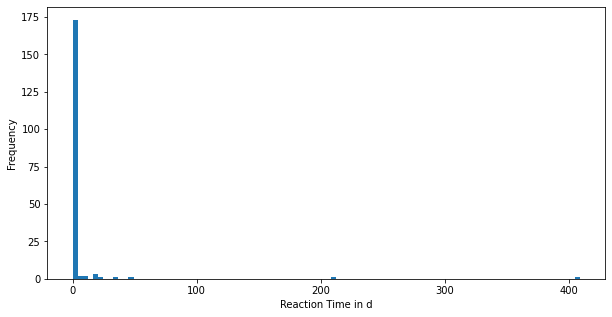

In [17]:
(customer_issues.time_to_react / pandas.Timedelta(days=1)).plot.hist(bins=100).set(xlabel='Reaction Time in d')

[Text(0.5, 0, 'Reaction Time in d')]

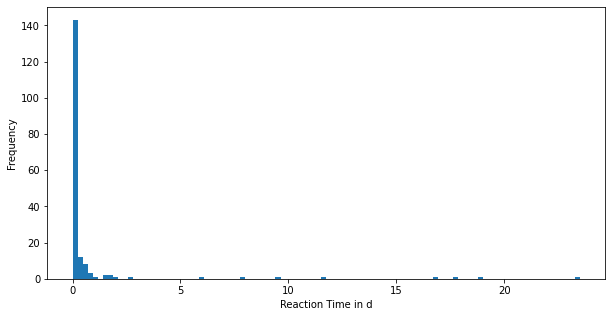

In [18]:
(customer_issues.time_to_react / pandas.Timedelta(days=1))[customer_issues.time_to_react <= timedelta(days=30)].plot.hist(bins=100).set(xlabel='Reaction Time in d')

In [19]:
customer_issues[customer_issues.time_to_react > timedelta(days=7)].issue.count()

11

In [20]:
focus_issues = customer_issues[customer_issues.time_to_react <= timedelta(days=7)]

In [21]:
issues_per_sprint = focus_issues.groupby('created_sprint')

### Explore the Data

<AxesSubplot:xlabel='created_sprint'>

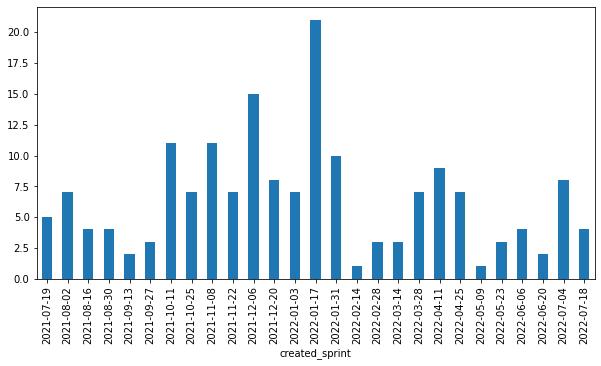

In [22]:
issues_per_sprint.issue.count().plot.bar()

<AxesSubplot:xlabel='created_sprint'>

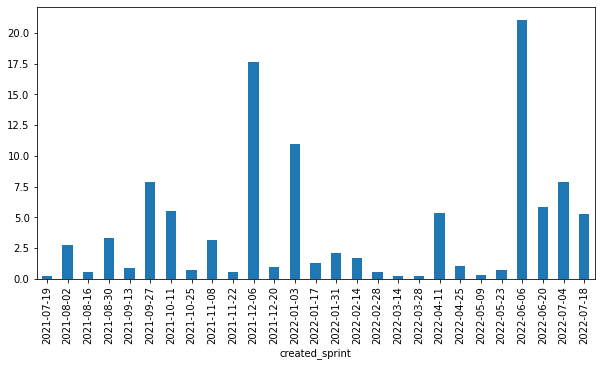

In [23]:
mean_time_to_react = issues_per_sprint.time_to_react.apply(numpy.mean)
(mean_time_to_react / pandas.Timedelta(hours=1)).plot.bar()

<AxesSubplot:xlabel='created_sprint'>

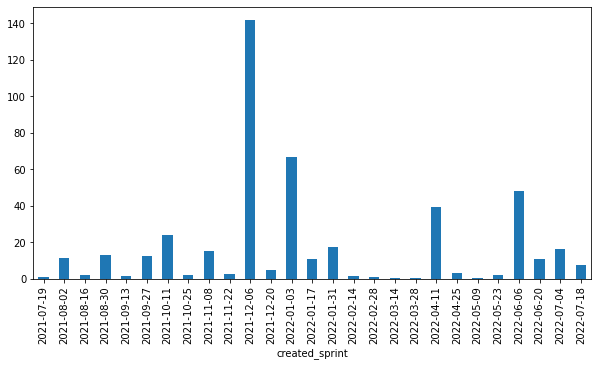

In [24]:
max_time_to_react = issues_per_sprint.time_to_react.apply(numpy.max)
(max_time_to_react / pandas.Timedelta(hours=1)).plot.bar()

<AxesSubplot:xlabel='created_sprint'>

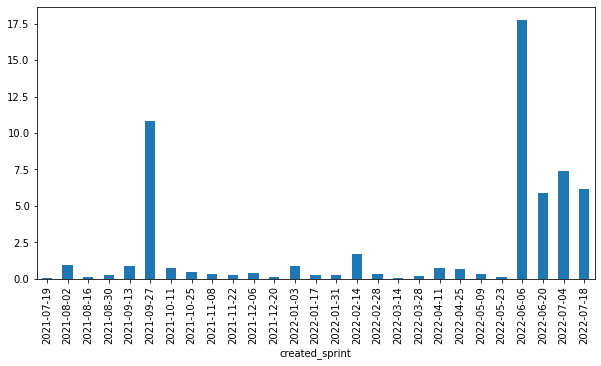

In [25]:
median_time_to_react = issues_per_sprint.time_to_react.apply(numpy.median)
(median_time_to_react / pandas.Timedelta(hours=1)).plot.bar()

### Finding Causes

In [26]:
problem_sprints = [datetime(2022, 6, 6), datetime(2022, 6, 20), datetime(2022, 7, 4), datetime(2022, 7, 18)]

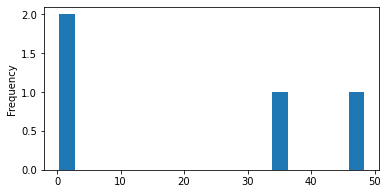

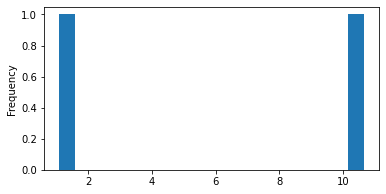

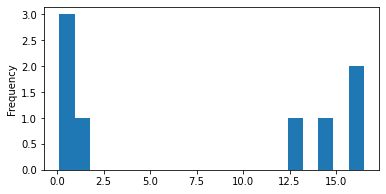

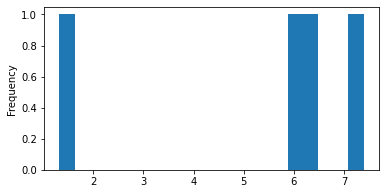

In [27]:
for sprint_begin in problem_sprints:
    pyplot.figure(figsize=(6, 3))
    (focus_issues[focus_issues.created_sprint == sprint_begin.date()].time_to_react / pandas.Timedelta(hours=1)).plot.hist(bins=20)

In [34]:
problem_issues = focus_issues[(focus_issues.created_at >= problem_sprints[0]) & (focus_issues.time_to_react >= timedelta(hours=10))]
problem_issues

,issue,issue_number,created_at,created_sprint,first_reaction,time_to_react
362,"Issue(title=""App shows new features note after...",5334,2022-07-10 18:43:02,2022-07-04,"IssueComment(user=NamedUser(login=""larswmh""), ...",0 days 14:26:27
363,"Issue(title=""Please merge version 2.24.2 into ...",5333,2022-07-10 18:30:50,2022-07-04,"IssueComment(user=NamedUser(login=""schauersber...",0 days 13:03:32
364,"Issue(title=""Missing 2.24.2 GitHub release"", n...",5332,2022-07-10 14:43:42,2022-07-04,"IssueComment(user=NamedUser(login=""schauersber...",0 days 16:27:58
372,"Issue(title=""Twitter Reports: App spams notifi...",5324,2022-07-05 13:54:48,2022-07-04,"IssueComment(user=NamedUser(login=""dsarkar""), ...",0 days 16:29:36
398,"Issue(title=""Strange time format on ID history...",5296,2022-06-22 20:57:51,2022-06-20,"IssueComment(user=NamedUser(login=""MikeMcC399""...",0 days 10:38:43
417,"Issue(title=""Twitter Report: ""Fertig"" button o...",5276,2022-06-11 21:52:37,2022-06-06,"IssueComment(user=NamedUser(login=""larswmh""), ...",1 days 10:45:31
419,"Issue(title=""Using back/forward buttons when r...",5274,2022-06-11 08:09:38,2022-06-06,"IssueComment(user=NamedUser(login=""larswmh""), ...",2 days 00:17:55


In [35]:
problem_issues['created_day'] = problem_issues.created_at.apply(lambda date: date.day_name())
problem_issues

/mnt/d/Users/Leon Bein/Documents/HPI/U_Masterarbeit/masterThesisCode/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,issue,issue_number,created_at,created_sprint,first_reaction,time_to_react,created_day
362,"Issue(title=""App shows new features note after...",5334,2022-07-10 18:43:02,2022-07-04,"IssueComment(user=NamedUser(login=""larswmh""), ...",0 days 14:26:27,Sunday
363,"Issue(title=""Please merge version 2.24.2 into ...",5333,2022-07-10 18:30:50,2022-07-04,"IssueComment(user=NamedUser(login=""schauersber...",0 days 13:03:32,Sunday
364,"Issue(title=""Missing 2.24.2 GitHub release"", n...",5332,2022-07-10 14:43:42,2022-07-04,"IssueComment(user=NamedUser(login=""schauersber...",0 days 16:27:58,Sunday
372,"Issue(title=""Twitter Reports: App spams notifi...",5324,2022-07-05 13:54:48,2022-07-04,"IssueComment(user=NamedUser(login=""dsarkar""), ...",0 days 16:29:36,Tuesday
398,"Issue(title=""Strange time format on ID history...",5296,2022-06-22 20:57:51,2022-06-20,"IssueComment(user=NamedUser(login=""MikeMcC399""...",0 days 10:38:43,Wednesday
417,"Issue(title=""Twitter Report: ""Fertig"" button o...",5276,2022-06-11 21:52:37,2022-06-06,"IssueComment(user=NamedUser(login=""larswmh""), ...",1 days 10:45:31,Saturday
419,"Issue(title=""Using back/forward buttons when r...",5274,2022-06-11 08:09:38,2022-06-06,"IssueComment(user=NamedUser(login=""larswmh""), ...",2 days 00:17:55,Saturday
